## Import Module/Library

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
import matplotlib
from PIL import Image

In [2]:
tf.__version__

'2.9.1'

In [3]:
!conda activate tf

/bin/bash: /home/notta/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)

CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


2022-07-07 17:40:08.705420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 17:40:08.728206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 17:40:08.728374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 17:40:08.730472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
gpus = tf.config.list_physical_devices('GPU')
logical_gpus = tf.config.list_logical_devices('GPU')
gpus, logical_gpus

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 [LogicalDevice(name='/device:GPU:0', device_type='GPU')])

## Config Parameters

In [6]:
########### YOUR CODE HERE ################
"""Khai báo tham số batchsize, shape image phù hợp 
với model các bạn sẽ xây dựng và đường dẫn đến data 
chứa 3 folder train, test và val"""

BATCH_SIZE  = 1
IMG_HEIGHT  = 256
IMG_WIDTH   = 256
IMG_CHANNEL = 3

# Path tới folder de-makeup data 
IMG_PATH =  "./makeup_data"
###########################################
BUFFER_SIZE = BATCH_SIZE*10

##  Load Data

Vì ảnh của de-makeup data đuược tạo ra với 1 sample (style, source, đã makeup), để load data cho de-makeup task chỉ cần chia ảnh làm 3 phần và lấy 2 phần cuối (srouce:chua makupe và makeup: đã makeup)

In [7]:
def load(image_file):
    ########### YOUR CODE HERE ################

    """Thực hiện các bước load ảnh và xử lý ảnh cơ bản
    Parameters
    ----------
    image_file : string 
        Path dẫn đến file ảnh.

    Returns
    -------
    input_image: tf.Tensor (tf.float32)
        ảnh input cho model (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target cho model (ảnh face chưa makeup).
    """
    
    # read file và decode ảnh
    
    
    # Split mỗi image tensor thành 2 tensors (2 ảnh):
    # - non-makeup image
    # - makeup image
    # chia ảnh làm 3 phần bằng nhau và chỉ lấy phần ảnh thứ 2 (ảnh chưa makeup) (target_image)
    # và thứ 3 (ảnh đã makeup) (input_image)
    
    
    # resize input_image và target_image theo size đã define ở trên
    
    
    # Convert cả 2 images, input_image và target_image thành float32 tensors
    # Read image
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    #Resize image 
    image  = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH*3))

    # Split image 
    target_image = image[:, IMG_WIDTH : IMG_WIDTH*2, :]
    input_image = image[:, IMG_WIDTH*2: :]
    
    # Convert to float32
    input_image  = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)
    return input_image, target_image
    ###########################################

(256, 256, 3)
(256, 256, 3)


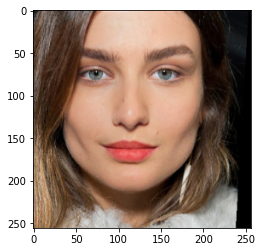

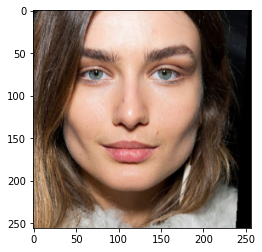

In [8]:
# test load function
input_image, target_image = load(str(IMG_PATH + '/train/0.png'))
print(input_image.shape)
print(target_image.shape)


plt.figure()
plt.imshow(input_image/255.0)
plt.figure()
plt.imshow(target_image/255.0)


Khi Load ảnh đúng sẽ có kết quả như sau 

![image-2.png](attachment:image-2.png)

In [9]:
@tf.function()
def random_flip(input_image, target_image):
     ########### YOUR CODE HERE ################

    """Thực hiện random 50% flip sang trái hoặc phải
    Parameters
    ----------
    input_image: tf.Tensor (tf.float32)
        ảnh input cho model (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target cho model (ảnh face chưa makeup).

    Returns
    -------
    input_image: tf.Tensor (tf.float32)
        ảnh input cho model đã random flip trái hoặc phải (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target cho model đã random flip trái hoặc phải (ảnh face chưa makeup).
    """
    # tỉ lệ random 50% flip sang trái hoặc phải
    if tf.random.uniform(()) > 0.5:
        input_image  = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)
    
    return input_image, target_image
    #############################################

    
def processing_image(input_image, target_image):
    ########### YOUR CODE HERE (Optional) ################
    """Tiền xử lý  ảnh trước khi đưa vào model, kỹ thuật xử lý ảnh này sẽ tùy thuộc vào pretrained model 
    mà người lập trình lựa chọn.
    Parameters
    ----------
    input_image: tf.Tensor (tf.float32)
        ảnh input cho model (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target cho model (ảnh face chưa makeup).

    Returns
    -------
    input_image: tf.Tensor (tf.float32)
        ảnh input đã qua tiền xử lý 
    target_image: tf.Tensor (tf.float32)
        ảnh target đã qua tiền xử lý
    """
    # tiền xử lý input_image

    # tiền xử lý target_image
    input_image  = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1

    ######################################################
    return input_image, target_image


def load_image_train(image_file):
    ########### YOUR CODE HERE ################

    """Thực hiện xử lý ảnh để đưa vào model để train
    Parameters
    ----------
    input_image: tf.Tensor (tf.float32)
        ảnh input cho model (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target cho model (ảnh face chưa makeup).

    Returns
    -------
    input_image: tf.Tensor (tf.float32)
        ảnh input đã xử lý cho model để train (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target đã xử lý cho model để train (ảnh face chưa makeup).
    """
     # load image
    input_image, target_image = load(image_file)

    # random_flip
    input_image, target_image = random_flip(input_image, target_image)

    # processing_image
    input_image, target_image = processing_image(input_image, target_image)
    
    return input_image, target_image
    #############################################


def load_image_val(image_file):
    """Thực hiện xử lý ảnh để đưa vào model thực hiện validation hoặc test
    Parameters
    ----------
    input_image: tf.Tensor (tf.float32)
        ảnh input cho model (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target cho model (ảnh face chưa makeup).

    Returns
    -------
    input_image: tf.Tensor (tf.float32)
        ảnh input đã xử lý cho model  (ảnh face đã makeup).
    target_image: tf.Tensor (tf.float32)
        ảnh target đã xử lý cho model (ảnh face chưa makeup).
    """
    # dùng hàm load để load ảnh 
    input_image, target_image = load(image_file)
    
    # dùng hàm processing_image để xử lý ảnh
    input_image, target_image = processing_image(input_image, target_image)
    
    return input_image, target_image
    #############################################

In [10]:
train_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/train/*.png'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


In [11]:
val_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/val/*.png'))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [31]:
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None))>

In [12]:
test_dataset = tf.data.Dataset.list_files(str(IMG_PATH + '/test/*.png'))
test_dataset = test_dataset.map(load_image_val)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build Model 

Ở đây các bạn tùy ý xây dựng model có kiến trúc dựa trên Unet. **Nhưng phải đảm bảo sử dụng được pretrained model cua Imagenet (vd: vgg16, vgg19, resnet50, ...)**

Dưới đây là ví dụ build Unet với backbone là resnet50 ở phần encoder. **Các bạn có thể không cần theo luồng code ở dưới mà xóa đi làm theo ý mình vẫn được**

![image.png](attachment:image.png)

In [13]:
class BuildRes50Unet():
    def __init__(self):
        ########### YOUR CODE HERE (Optional) ################
        """Khai báo 2 attribute của class chứa layer name của backbone
        Attributes
        ----------
        self.encoder_blocks_name: list
            list tên các layer trong pretrained model được lấy ra tham gia vào encoder 
        self.bridge_block_name: list
            tên layer trong pretrained model được lấy ra tham gia vào thành phần bridge của Unet 
        """
        # khai báo self.encoder_blocks_name
        
        # khai báo self.bridge_block_name
        pass
        
        ######################################################
        
    
    def conv_block(self, inputs, num_filters):
        ########### YOUR CODE HERE (Optional) ################
        """Thực hiện 2 lần convolution liên tiếp 
        Parameters
        ----------
        inputs: tf.Tensor 
            tensor đi qua các layer trong model
        num_filters: int 
            số lượng filters

        Returns
        -------
        x: tf.Tensor 
            kết quả inputs đi qua 2 convlution block (Conv2D, BatchNormalization, Activation function)
        """
        
        # sử dụng Conv2D (filters=num_filters, kernel_size=(3,3), padding="same")
        # convlution block 1
        
        # sử dụng Conv2D (filters=num_filters, kernel_size=(3,3), padding="same")
        # convlution block 2
        # Init weight
        initializer = tf.random_normal_initializer(0., 0.02)

        # Conv 1
        x = layers.Conv2D(num_filters, 3, strides=1, padding='same',
                          kernel_initializer=initializer, use_bias=False)(inputs)
        x = layers.LayerNormalization()(x)
        x = layers.LeakyReLU()(x)

        # Conv 2
        x = layers.Conv2D(num_filters, 3, strides=1, padding='same',
                          kernel_initializer=initializer, use_bias=False)(x)
        x = layers.LayerNormalization()(x)
        x = layers.LeakyReLU()(x)
        return x
        ######################################################
        
    
    
    def upsample_concate_block(self, inputs, skip_connection, num_filters):
        ########### YOUR CODE HERE (Optional) ################
        """Thực hiện Upsampling, skip connection và đi qua 2 convolution block
        Parameters
        ----------
        inputs: tf.Tensor 
            tensor đi qua các layer trong model
        skip_connection: tf.Tensor 
            tensor thực hiện skip connection 
        num_filters: int 
            số lượng filters

        Returns
        -------
        x: tf.Tensor 
            kết quả inputs upsampling saud đó concatenate với skip connection 
            rồi đi qua 2 convlution block
        """
        
         # Upsampling 
        x = layers.UpSampling2D(interpolation='bilinear')(inputs)

        # Concatenate tensor upsample and skip connection
        x = layers.Concatenate()([x, skip_connection])

        # Via 2 convolution block
        x = self.conv_block(x, num_filters)
        
        return x
        ######################################################

    
    
    def build_model(self, input_shape):
        ########### YOUR CODE HERE (Optional) ################
        """Build Unet architecture sử dụng pretrained backbone (encoder)
        Parameters
        ----------
        input_shape: Tuple  
            shape input cuả model 
            
        Returns
        -------
        model: tf.keras.Model
            Unet model 
        """
        # khai báo input layer 
        
        
        # encoder
        ## get pretrained backbone (loại bỏ top, weight dùng imagenet, input là input tensor ở trên)
        
        ## lấy 4 output tensor theo tên các layer trong self.encoder_blocks_name
        
        
        # bridge: lấy output tensor theo tên các layer trong self.bridge_block_name 
        
        
        # decoder
        ## dùng method upsample_concate_block để upsampling, concatenate skip connection
        ## và đi qua 2 convolutional block. Thực hiện với 4 output tensor ở encoder
        
        
        # final output
        ## inputs tensor đi qua 1 Conv2D(ilters=64, kernel_size=(3,3), padding='same') để lấy input feature
        
        ## thực hiện upsample_concate_block với input feature và kết quả cuối của decoder 
        
        ## đi qua Conv2D kernel_size=(1,1) để tạo ra ảnh cùng kích thước ảnh input và có 3 channel
        ## Lưu ý lựa chọn activation phù hợp với giá trị ảnh target đã qua tiền xử lý
        
        ## build model 
         # Input layer 
        inputs = layers.Input(shape=input_shape)

        # Encoder

        # Get pretrained backbone 
        """ Pre-trained ResNet50 Model """
        resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

        """ Encoder """
        s1 = resnet50.layers[0].output         
        s2 = resnet50.get_layer("conv1_relu").output        
        s3 = resnet50.get_layer("conv2_block3_out").output  
        s4 = resnet50.get_layer("conv3_block4_out").output  

        """ Bridge """
        b1 = resnet50.get_layer("conv4_block6_out").output  

        """ Decoder """
        d1 = self.upsample_concate_block(b1, s4, 512)             
        d2 = self.upsample_concate_block(d1, s3, 256)                  
        d3 = self.upsample_concate_block(d2, s2, 128)                   
        d4 = self.upsample_concate_block(d3, s1, 64)  
        
        """ Output """
        # Use tanh for output [-1: 1]
        outputs = layers.Conv2D(filters=input_shape[-1], kernel_size=(1,1), activation='tanh',
                                      kernel_initializer='he_normal', use_bias=False)(d4)
        
        # Value input and output [-1:1]
        model = Model(inputs=[inputs], outputs=[outputs])
        
        return model
        ######################################################

In [14]:
model = BuildRes50Unet()
res50Unet = model.build_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))

In [15]:
# res50Unet.summary()
model = BuildRes50Unet()
res50Unet = model.build_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))
res50Unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Config and Compile Model

### Show Generated Images and Evaluation Function

In [16]:
def evaluate(model, epoch, dataset):  
    psnr_mean = 0.0
    count = 0
    for inputs, targets in dataset:
        fake = model([inputs], training=True)
        
        ########### YOUR CODE HERE ################
        """ fake và target nên biến đổi về range phù hợp với max_val ở ví dụ này 
        max là 1.0 cho range [0,1]
        Example: 
        --------
        psnr = tf.image.psnr(fake, targets, max_val=1.0)  
        """ 
        # Scale to [0,1] and compute PSNR
        psnr = tf.image.psnr(fake*0.5 + 0.5, targets*0.5 + 0.5, max_val=1.0)

        __psnr_mean = tf.math.reduce_mean(psnr)
        
        psnr_mean += __psnr_mean
        count =count + 1
    
    psnr_mean = psnr_mean/count
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch, '  count: ', count)
    
    return psnr_mean
    

def generate_images(model, inputs, targets, epoch, pnsr):
    fake = model([inputs], training=True)
    plt.figure(figsize=(15,20))
    
    ########### YOUR CODE HERE (Optional) ################
    """ lấy ảnh đầu tiên của batch trong inputs, targets và fake
    sau đó scale về giá trị phù hợp để hiển thị theo matplotlib
    Note: matplotlib chỉ hiển thị được range [0,1] nếu dtype là float,
    và [0,255] nếu dtype là uint8
    Example: 
    --------
    display_list = [inputs[0], targets[0], fake[0]]
        
    """ 
     # Get one images
    display_list = [inputs[0], targets[0], fake[0]]
    title = ['Input', 'Real', 'Predicted']    

    # Save output better performance than 
    output = np.concatenate([display_list[0], display_list[1], display_list[2]], axis=1)
    output = (output * 0.5 + 0.5) * 255
    output = output.astype(np.uint8)
    Image.fromarray(output).save(f"./save_result/validation_results/epoch:{epoch} pnsr:{pnsr}.png")
    #######################################################
    
    title = ['Input', 'Real', 'Predicted']    

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()       

### Create Folder to save result


In [17]:
os.makedirs("./save_result", exist_ok=True)
os.makedirs("./save_result/validation_results", exist_ok=True)
os.makedirs("./save_result/testing_results", exist_ok=True)
os.makedirs("./save_result/save_model", exist_ok=True)

### Loss

L1 loss

![image.png](attachment:image.png)

Perceptual Loss

![image.png](attachment:image.png)

In [18]:
class PeceptualLoss():
    def __init__(self, input_shape):
        ########### YOUR CODE HERE (Optional) ################
        """Khai báo 3 attribute của class chứa layer name của backbone extractor, extractor và preprocessing
        Attributes
        ----------
        self.layer_names: list
            list tên các layer trong pretrained model được lấy ra tham gia vào encoder 
        self.extractor: tf.keras.Model
            Model extract các features theo các layer name trong self.layer_names
        self.vgg_preprocessing: list
            Hàm sử lý cho bước processing vgg19
        
        Parameters
        ----------
        input_shape: tuple 
            shape của input dùng cho model extractor
        """
        # khai báo self.layer_names (tên các layer cần lấy)
        
        # self.extractor lấy model bằng cách gọi hàm self.get_extractor để lấy model extract các features
        # (cụ thể ở đây dùng vgg19)

        # self.vgg_preprocessing lấy hàm preprocess input (cụ thể ở đây dùng vgg19)
        ######################################################
        self.layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4', 'block5_conv4']
        self.extractor = self.get_extractor(input_shape)
        self.MSE = tf.keras.losses.MeanSquaredError()
        self.vgg_preprocessing = tf.keras.applications.vgg19.preprocess_input
    
    
    def get_extractor(self, input_shape):
        ########### YOUR CODE HERE (Optional) ################
        """Thực hiện lấy pretrained model, trích xuất output các block để tạo model lấy các features
        Parameters
        ----------
        input_shape: tuple 
            shape của input dùng cho model extractor

        Returns
        -------
        model:  tf.keras.Model 
            pretrained model (cụ thể là vgg19) để extract các feature dùng cho perceptual loss
        """
        
        # lấy pretrained model vgg19, bỏ top, weights là imagenet, input_shape và fix weight ko cho cập nhật 
        
        # lấy các outputs layer cần thiết theo layer name trong self.layer_names
        
        # Xây dưng model input theo input_shape và output là các output layers có tên trong self.layer_names
        
        vgg = tf.keras.applications.VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
        vgg.trainable = False
        outputs = [vgg.get_layer(name).output for name in self.layer_names]
        model = Model(inputs=vgg.input, outputs=outputs)
        
        return model
        ######################################################
        
        
    def percep_loss(self, target_image, fake_image):
        ########### YOUR CODE HERE (Optional) ################
        """Thực hiện perceptual loss theo target_image và fake_image
        Parameters
        ----------
        target_image: tf.tensor  
            tensor gồm 1 mini batch chứa các ảnh không makeup 
        fake_image: tf.tensor  
            tensor gồm 1 mini batch chứa các ảnh model tạo ra ảnh không makeup  
        Returns
        -------
        loss:  tf.tensor
            perceptual loss
        """
        
        # vì target_image và fake_image [0, 1] nên cần nhân 255 để khôi phục lại ảnh gốc trước khi vào bước preprocessing 
        
        
        # dùng self.vgg_preprocessing để preprocessing target_image và fake_image
        
        
        # dùng self.extractor để lấy các features của cả target_image và fake_image
        
        
        # tính loss dựa trên các features và lấy trung bình 
        
        target_image *= 255.0
        fake_image *= 255.0
        
        target_image = self.vgg_preprocessing(target_image)
        fake_image = self.vgg_preprocessing(fake_image)
        
        target_features = self.extractor(target_image)
        fake_features = self.extractor(fake_image)
        
        loss = tf.add_n([tf.reduce_mean((tar_fea-fk_fea)**2) 
                         for  tar_fea, fk_fea in zip(target_features, fake_features)])
        loss = loss/len(fake_features)
        return loss
        ######################################################
        

In [19]:
per_loss = PeceptualLoss(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL))

In [20]:
def generator_loss(fake, target, loss_type='L1'):
    loss_list = ["L1", "Percep"]
    assert loss_type in loss_list
    # L1 loss
    if loss_type == loss_list[0]:
        loss = tf.reduce_mean(tf.abs(fake-target))

    # Perceptual Loss
    elif loss_type == loss_list[1]:
        loss = per_loss.percep_loss(target, fake)
    return loss

### Optimizer

In [21]:
########### YOUR CODE HERE (Optional) ################
"""lựa chọn optimizer phù hợp 
Example: 
--------
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
"""
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
######################################################

## Training

In [22]:
########### YOUR CODE HERE (Optional) ################
"""lựa chọ loss cần dùng
Example: 
--------
loss_type='L1'
loss_type='Percep'
"""  
LOSS_TYPE = 'Percep'
###########################################

In [23]:
@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        # output
        fake = res50Unet([inputs], training=True)     
        loss = generator_loss(fake, targets, LOSS_TYPE)
        
    generator_gradients = tape.gradient(loss, res50Unet.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, res50Unet.trainable_variables))
    
    return loss

    
    
def fit(train_ds, epochs, val_ds):
    best_pnsr = 0.0
    for epoch in range(epochs):
        # Train
        total_loss = 0.0
        for inputs, targets in train_ds:
            loss = train_step(inputs, targets)
            total_loss = total_loss + loss

        total_loss = (total_loss/len(train_ds))*100
        print('epoch: {}   loss: {}'.format(epoch, total_loss))
        
        pnsr = evaluate(res50Unet, epoch, val_ds)        
        if best_pnsr < pnsr:
            best_pnsr = pnsr
            res50Unet.save("./save_model/model-resnet-50-unet.h5")
            for inputs, targets in val_ds.take(1):
                generate_images(res50Unet, inputs, targets, epoch, best_pnsr)
                print("Save result successfully!")


2022-07-07 17:40:20.117798: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-07 17:40:21.008479: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-07-07 17:40:22.306550: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this fe

epoch: 0   loss: 7257037.5
-------- psnr:  23.215618    ----- epoch:  0   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


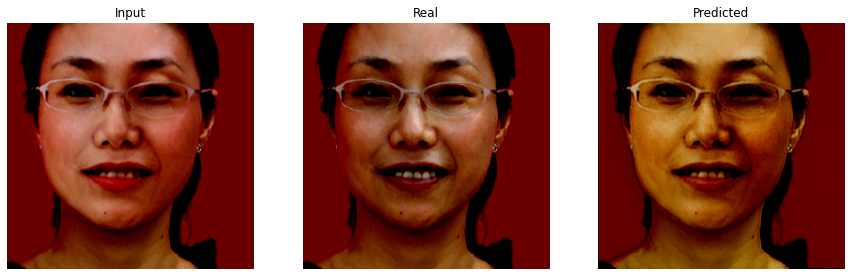

Save result successfully!
epoch: 1   loss: 3430810.5
-------- psnr:  24.623508    ----- epoch:  1   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


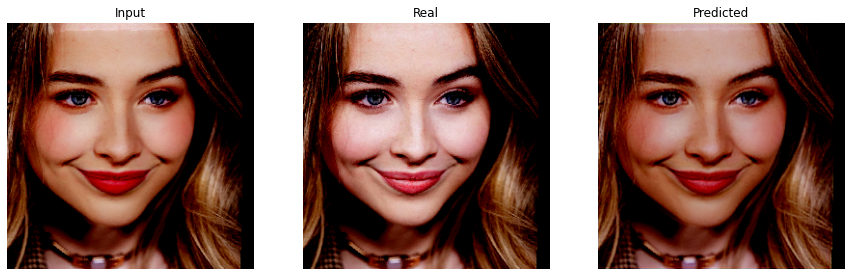

Save result successfully!
epoch: 2   loss: 2820192.0
-------- psnr:  25.880142    ----- epoch:  2   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


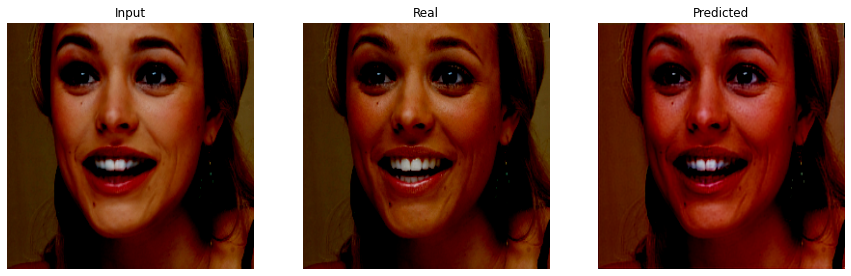

Save result successfully!
epoch: 3   loss: 2534537.0
-------- psnr:  26.326841    ----- epoch:  3   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


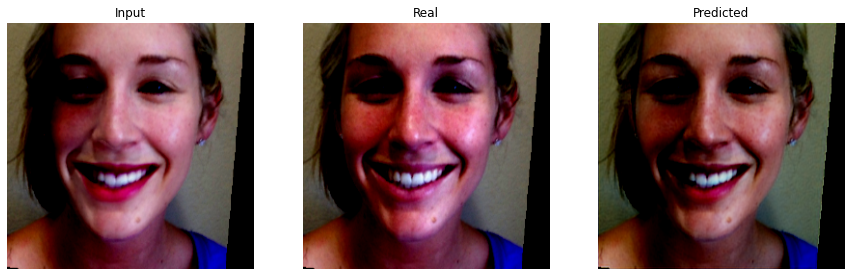

Save result successfully!
epoch: 4   loss: 2307035.5
-------- psnr:  26.52702    ----- epoch:  4   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


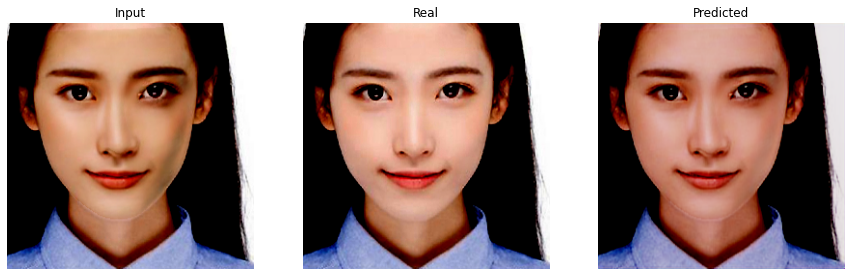

Save result successfully!
epoch: 5   loss: 2098775.5
-------- psnr:  26.55209    ----- epoch:  5   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


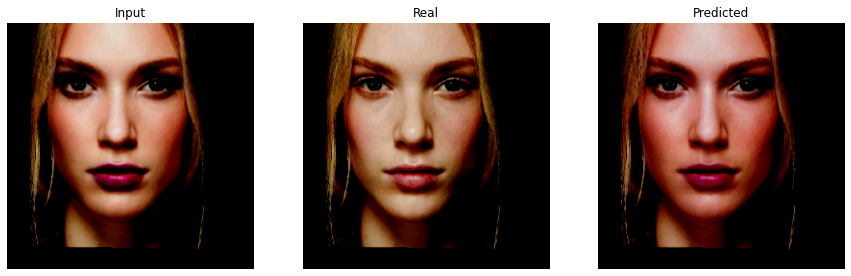

Save result successfully!
epoch: 6   loss: 1949368.375
-------- psnr:  26.057228    ----- epoch:  6   count:  100
epoch: 7   loss: 1859490.625
-------- psnr:  28.193611    ----- epoch:  7   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


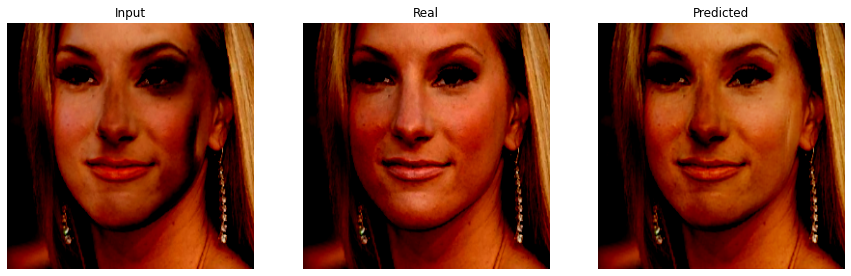

Save result successfully!
epoch: 8   loss: 1732879.875
-------- psnr:  26.94594    ----- epoch:  8   count:  100
epoch: 9   loss: 1659222.25
-------- psnr:  27.732422    ----- epoch:  9   count:  100
epoch: 10   loss: 1566794.875
-------- psnr:  27.92193    ----- epoch:  10   count:  100
epoch: 11   loss: 1496395.0
-------- psnr:  27.403852    ----- epoch:  11   count:  100
epoch: 12   loss: 1439174.125
-------- psnr:  28.35718    ----- epoch:  12   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


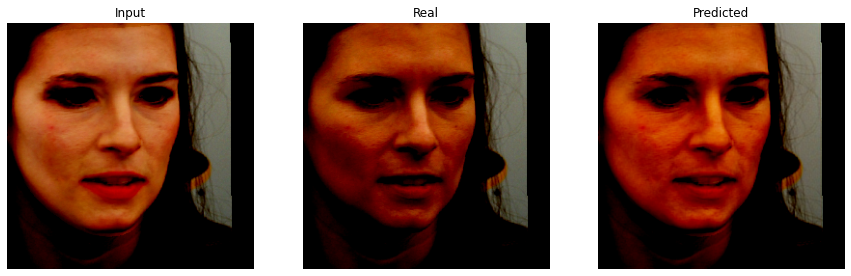

Save result successfully!
epoch: 13   loss: 1372053.625
-------- psnr:  27.55166    ----- epoch:  13   count:  100
epoch: 14   loss: 1317344.375
-------- psnr:  28.774544    ----- epoch:  14   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


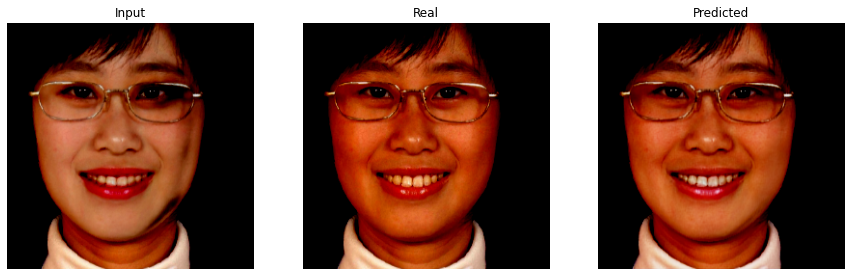

Save result successfully!
epoch: 15   loss: 1267128.125
-------- psnr:  28.879751    ----- epoch:  15   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


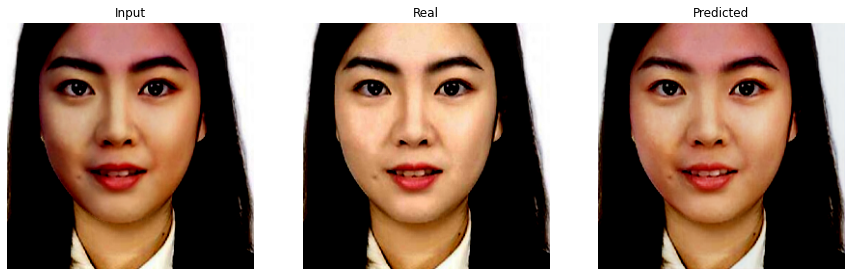

Save result successfully!
epoch: 16   loss: 1215278.875
-------- psnr:  29.043264    ----- epoch:  16   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


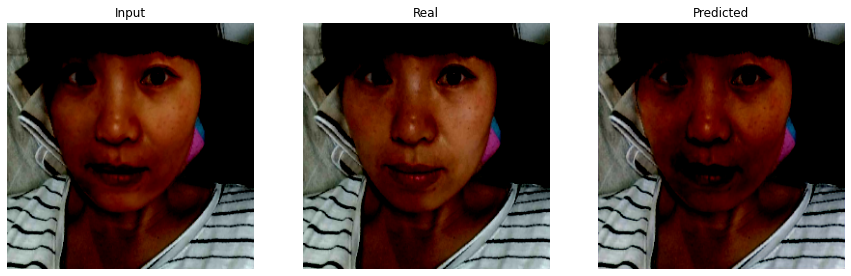

Save result successfully!
epoch: 17   loss: 1175746.625
-------- psnr:  28.681526    ----- epoch:  17   count:  100
epoch: 18   loss: 1130079.25
-------- psnr:  29.020725    ----- epoch:  18   count:  100
epoch: 19   loss: 1092912.625
-------- psnr:  28.724924    ----- epoch:  19   count:  100
epoch: 20   loss: 1064764.875
-------- psnr:  28.960737    ----- epoch:  20   count:  100
epoch: 21   loss: 1026308.625
-------- psnr:  29.112368    ----- epoch:  21   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


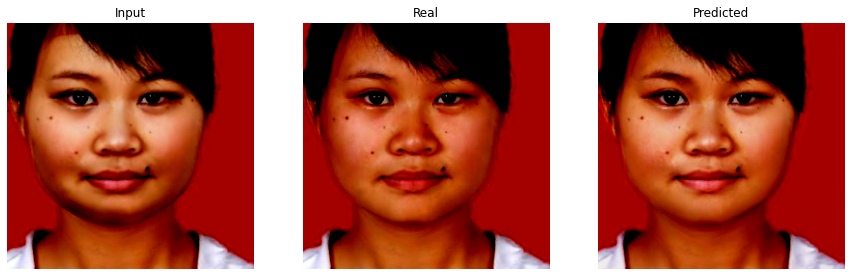

Save result successfully!
epoch: 22   loss: 991917.0
-------- psnr:  28.849747    ----- epoch:  22   count:  100
epoch: 23   loss: 963152.5625
-------- psnr:  29.165308    ----- epoch:  23   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


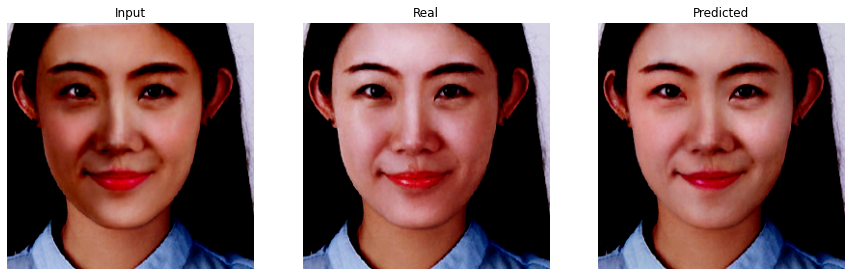

Save result successfully!
epoch: 24   loss: 942740.8125
-------- psnr:  29.060366    ----- epoch:  24   count:  100
epoch: 25   loss: 907411.8125
-------- psnr:  28.891579    ----- epoch:  25   count:  100
epoch: 26   loss: 888564.1875
-------- psnr:  29.160686    ----- epoch:  26   count:  100
epoch: 27   loss: 870489.9375
-------- psnr:  29.375994    ----- epoch:  27   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


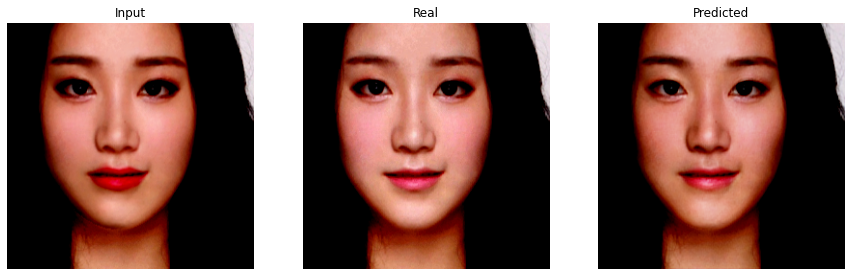

Save result successfully!
epoch: 28   loss: 842611.125
-------- psnr:  29.295557    ----- epoch:  28   count:  100
epoch: 29   loss: 816091.1875
-------- psnr:  29.456394    ----- epoch:  29   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


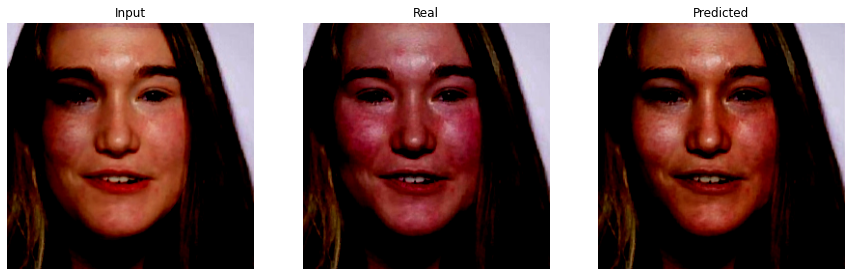

Save result successfully!
epoch: 30   loss: 794340.6875
-------- psnr:  29.194721    ----- epoch:  30   count:  100
epoch: 31   loss: 772941.3125
-------- psnr:  29.187614    ----- epoch:  31   count:  100
epoch: 32   loss: 757669.9375
-------- psnr:  29.545277    ----- epoch:  32   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


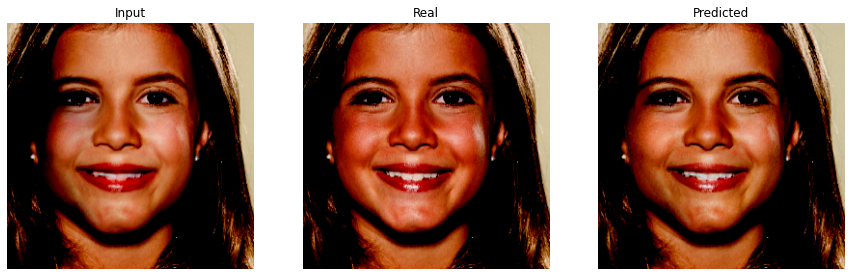

Save result successfully!
epoch: 33   loss: 737530.0625
-------- psnr:  29.463526    ----- epoch:  33   count:  100
epoch: 34   loss: 722275.4375
-------- psnr:  29.417725    ----- epoch:  34   count:  100
epoch: 35   loss: 706016.5
-------- psnr:  29.230478    ----- epoch:  35   count:  100
epoch: 36   loss: 690505.25
-------- psnr:  29.473736    ----- epoch:  36   count:  100
epoch: 37   loss: 678570.6875
-------- psnr:  29.481356    ----- epoch:  37   count:  100
epoch: 38   loss: 655331.8125
-------- psnr:  29.47064    ----- epoch:  38   count:  100
epoch: 39   loss: 649410.125
-------- psnr:  29.279968    ----- epoch:  39   count:  100
epoch: 40   loss: 641451.25
-------- psnr:  29.513086    ----- epoch:  40   count:  100
epoch: 41   loss: 626292.375
-------- psnr:  29.58627    ----- epoch:  41   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


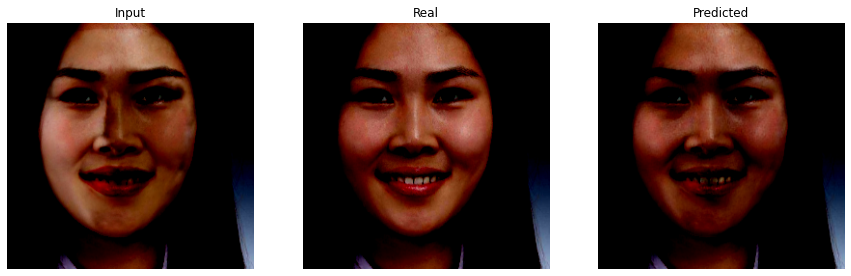

Save result successfully!
epoch: 42   loss: 609705.875
-------- psnr:  28.851284    ----- epoch:  42   count:  100
epoch: 43   loss: 605460.4375
-------- psnr:  29.579798    ----- epoch:  43   count:  100
epoch: 44   loss: 594157.25
-------- psnr:  29.61927    ----- epoch:  44   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


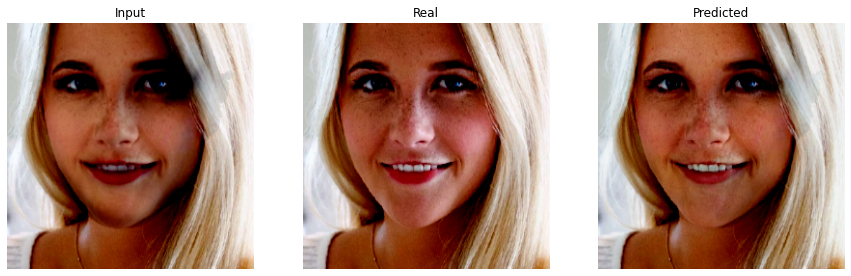

Save result successfully!
epoch: 45   loss: 583615.0
-------- psnr:  29.32509    ----- epoch:  45   count:  100
epoch: 46   loss: 578997.8125
-------- psnr:  29.657112    ----- epoch:  46   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


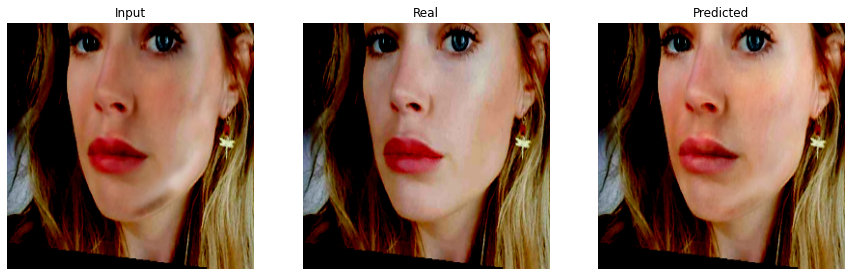

Save result successfully!
epoch: 47   loss: 559888.3125
-------- psnr:  29.63602    ----- epoch:  47   count:  100
epoch: 48   loss: 554363.375
-------- psnr:  29.554014    ----- epoch:  48   count:  100
epoch: 49   loss: 544723.75
-------- psnr:  29.535461    ----- epoch:  49   count:  100
epoch: 50   loss: 536695.1875
-------- psnr:  29.653563    ----- epoch:  50   count:  100
epoch: 51   loss: 532599.9375
-------- psnr:  29.655457    ----- epoch:  51   count:  100
epoch: 52   loss: 521260.5625
-------- psnr:  29.306099    ----- epoch:  52   count:  100
epoch: 53   loss: 518133.0
-------- psnr:  29.66073    ----- epoch:  53   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


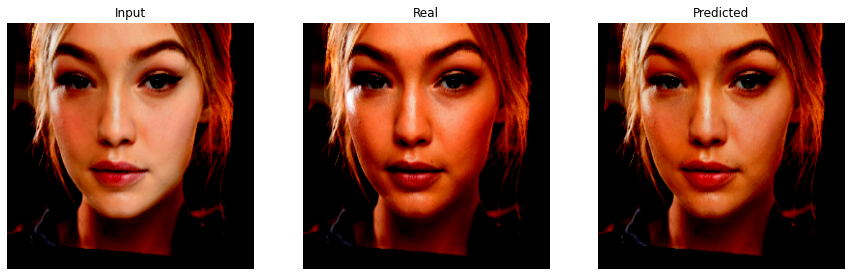

Save result successfully!
epoch: 54   loss: 502967.1875
-------- psnr:  29.63139    ----- epoch:  54   count:  100
epoch: 55   loss: 498671.9375
-------- psnr:  29.776052    ----- epoch:  55   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


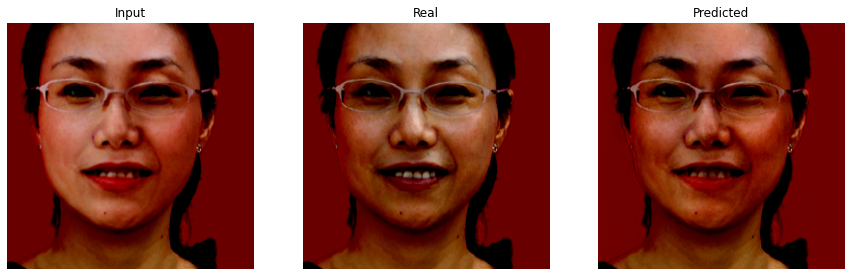

Save result successfully!
epoch: 56   loss: 494188.4375
-------- psnr:  29.190598    ----- epoch:  56   count:  100
epoch: 57   loss: 485544.25
-------- psnr:  29.684826    ----- epoch:  57   count:  100
epoch: 58   loss: 478483.6875
-------- psnr:  29.5866    ----- epoch:  58   count:  100
epoch: 59   loss: 469633.75
-------- psnr:  29.7459    ----- epoch:  59   count:  100
epoch: 60   loss: 466472.71875
-------- psnr:  29.72573    ----- epoch:  60   count:  100
epoch: 61   loss: 460940.03125
-------- psnr:  29.65523    ----- epoch:  61   count:  100
epoch: 62   loss: 456583.59375
-------- psnr:  29.670826    ----- epoch:  62   count:  100
epoch: 63   loss: 450830.28125
-------- psnr:  29.763794    ----- epoch:  63   count:  100
epoch: 64   loss: 442055.375
-------- psnr:  29.838015    ----- epoch:  64   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


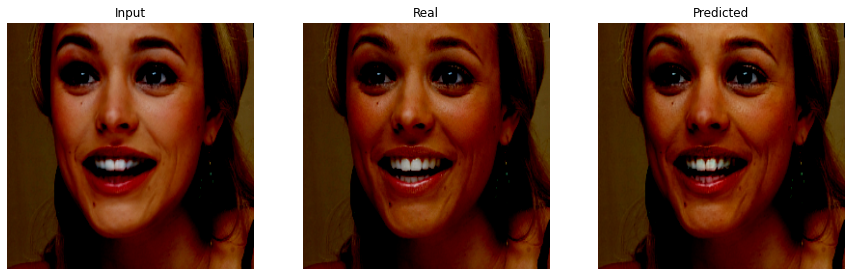

Save result successfully!
epoch: 65   loss: 439573.5
-------- psnr:  29.302078    ----- epoch:  65   count:  100
epoch: 66   loss: 431589.3125
-------- psnr:  29.580803    ----- epoch:  66   count:  100
epoch: 67   loss: 426807.75
-------- psnr:  29.670523    ----- epoch:  67   count:  100
epoch: 68   loss: 424194.25
-------- psnr:  29.848234    ----- epoch:  68   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


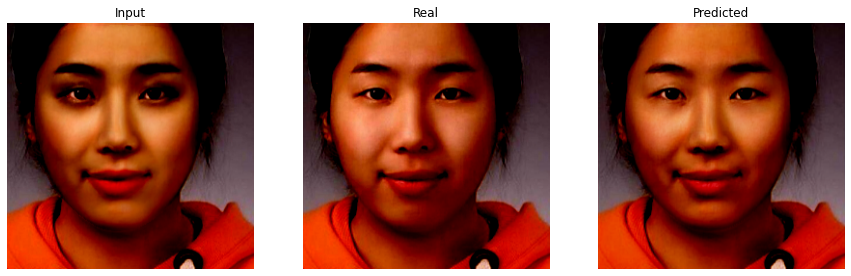

Save result successfully!
epoch: 69   loss: 418743.5
-------- psnr:  29.673195    ----- epoch:  69   count:  100
epoch: 70   loss: 412242.875
-------- psnr:  29.648602    ----- epoch:  70   count:  100
epoch: 71   loss: 405861.8125
-------- psnr:  29.894314    ----- epoch:  71   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


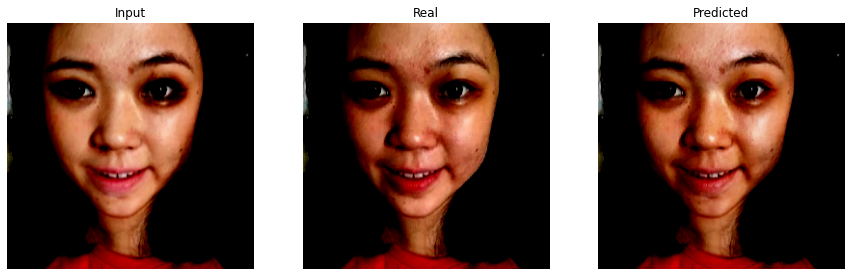

Save result successfully!
epoch: 72   loss: 405290.84375
-------- psnr:  29.731474    ----- epoch:  72   count:  100
epoch: 73   loss: 397847.0
-------- psnr:  29.73857    ----- epoch:  73   count:  100
epoch: 74   loss: 391749.6875
-------- psnr:  29.66635    ----- epoch:  74   count:  100
epoch: 75   loss: 391233.125
-------- psnr:  29.708145    ----- epoch:  75   count:  100
epoch: 76   loss: 386627.5625
-------- psnr:  29.892735    ----- epoch:  76   count:  100
epoch: 77   loss: 382213.59375
-------- psnr:  29.790064    ----- epoch:  77   count:  100
epoch: 78   loss: 378199.96875
-------- psnr:  29.789658    ----- epoch:  78   count:  100
epoch: 79   loss: 376620.9375
-------- psnr:  29.637915    ----- epoch:  79   count:  100
epoch: 80   loss: 372071.15625
-------- psnr:  29.78164    ----- epoch:  80   count:  100
epoch: 81   loss: 365112.5625
-------- psnr:  29.75368    ----- epoch:  81   count:  100
epoch: 82   loss: 360706.53125
-------- psnr:  29.87396    ----- epoch:  82   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


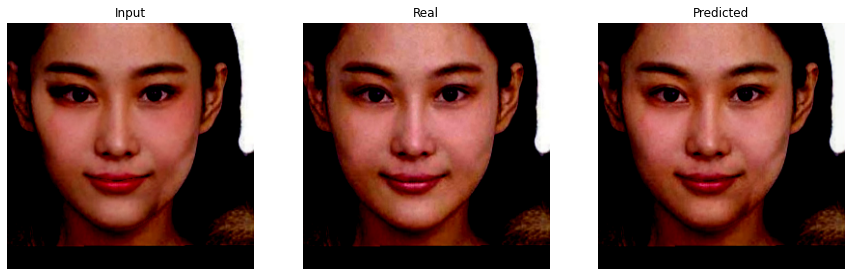

Save result successfully!
epoch: 87   loss: 344999.84375
-------- psnr:  29.922224    ----- epoch:  87   count:  100
epoch: 88   loss: 346561.3125
-------- psnr:  29.920805    ----- epoch:  88   count:  100
epoch: 89   loss: 342926.28125
-------- psnr:  29.877878    ----- epoch:  89   count:  100
epoch: 90   loss: 339709.28125
-------- psnr:  29.983686    ----- epoch:  90   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


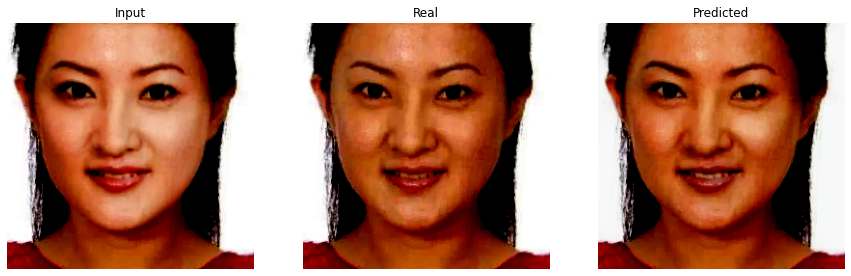

Save result successfully!
epoch: 91   loss: 334958.75
-------- psnr:  29.771694    ----- epoch:  91   count:  100
epoch: 92   loss: 330776.53125
-------- psnr:  29.691528    ----- epoch:  92   count:  100
epoch: 93   loss: 326732.9375
-------- psnr:  29.827444    ----- epoch:  93   count:  100
epoch: 94   loss: 325805.96875
-------- psnr:  29.702187    ----- epoch:  94   count:  100
epoch: 95   loss: 326691.25
-------- psnr:  29.836449    ----- epoch:  95   count:  100
epoch: 96   loss: 318832.5625
-------- psnr:  29.90175    ----- epoch:  96   count:  100
epoch: 97   loss: 319457.6875
-------- psnr:  29.9659    ----- epoch:  97   count:  100
epoch: 98   loss: 314636.6875
-------- psnr:  29.868698    ----- epoch:  98   count:  100
epoch: 99   loss: 311923.375
-------- psnr:  29.913017    ----- epoch:  99   count:  100
epoch: 100   loss: 307836.8125
-------- psnr:  29.762009    ----- epoch:  100   count:  100
epoch: 101   loss: 309348.1875
-------- psnr:  29.75252    ----- epoch:  101  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


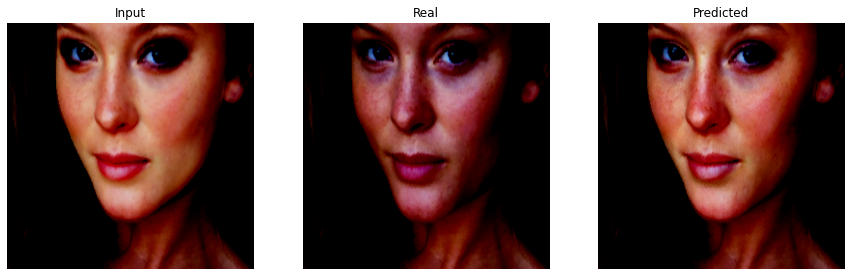

Save result successfully!
epoch: 104   loss: 300442.90625
-------- psnr:  29.690125    ----- epoch:  104   count:  100
epoch: 105   loss: 298144.21875
-------- psnr:  30.035374    ----- epoch:  105   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


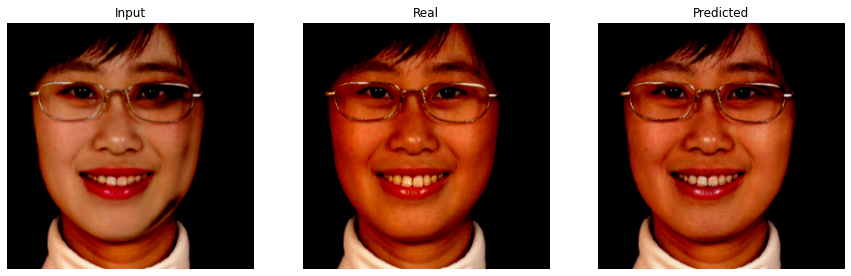

Save result successfully!
epoch: 106   loss: 296294.5625
-------- psnr:  29.979843    ----- epoch:  106   count:  100
epoch: 107   loss: 291647.71875
-------- psnr:  29.8219    ----- epoch:  107   count:  100
epoch: 108   loss: 290150.28125
-------- psnr:  29.53293    ----- epoch:  108   count:  100
epoch: 109   loss: 287091.75
-------- psnr:  29.97772    ----- epoch:  109   count:  100
epoch: 110   loss: 286028.625
-------- psnr:  29.961105    ----- epoch:  110   count:  100
epoch: 111   loss: 287914.5625
-------- psnr:  29.918613    ----- epoch:  111   count:  100
epoch: 112   loss: 281884.5
-------- psnr:  29.970617    ----- epoch:  112   count:  100
epoch: 113   loss: 278198.28125
-------- psnr:  29.959873    ----- epoch:  113   count:  100
epoch: 114   loss: 276881.375
-------- psnr:  29.919048    ----- epoch:  114   count:  100
epoch: 115   loss: 275941.71875
-------- psnr:  29.987942    ----- epoch:  115   count:  100
epoch: 116   loss: 274620.15625
-------- psnr:  29.675879    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


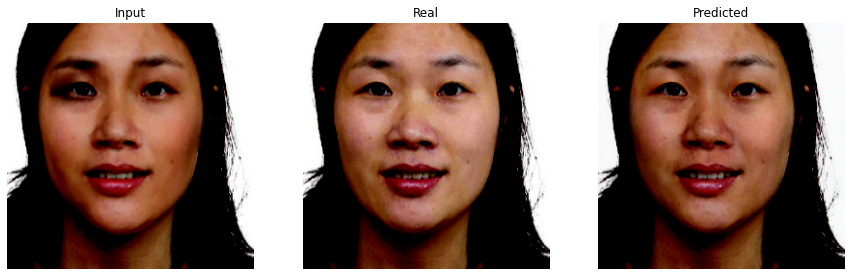

Save result successfully!
epoch: 130   loss: 251318.453125
-------- psnr:  29.878925    ----- epoch:  130   count:  100
epoch: 131   loss: 246680.15625
-------- psnr:  29.97881    ----- epoch:  131   count:  100
epoch: 132   loss: 246876.3125
-------- psnr:  29.978662    ----- epoch:  132   count:  100
epoch: 133   loss: 246388.40625
-------- psnr:  30.04778    ----- epoch:  133   count:  100
epoch: 134   loss: 245295.734375
-------- psnr:  30.080582    ----- epoch:  134   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


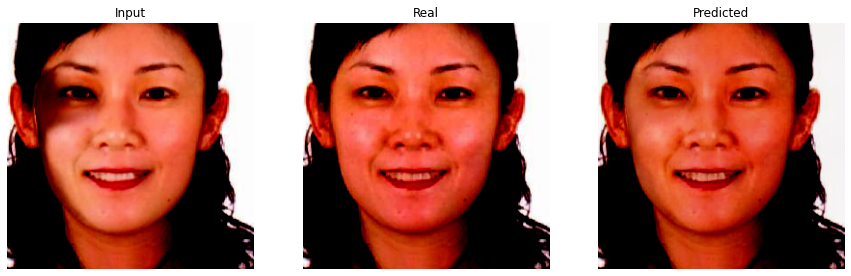

Save result successfully!
epoch: 135   loss: 242312.6875
-------- psnr:  29.81039    ----- epoch:  135   count:  100
epoch: 136   loss: 241901.53125
-------- psnr:  29.995007    ----- epoch:  136   count:  100
epoch: 137   loss: 239296.921875
-------- psnr:  29.76525    ----- epoch:  137   count:  100
epoch: 138   loss: 237411.75
-------- psnr:  30.012632    ----- epoch:  138   count:  100
epoch: 139   loss: 235257.78125
-------- psnr:  29.892527    ----- epoch:  139   count:  100
epoch: 140   loss: 235759.984375
-------- psnr:  30.008856    ----- epoch:  140   count:  100
epoch: 141   loss: 235985.328125
-------- psnr:  30.108242    ----- epoch:  141   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


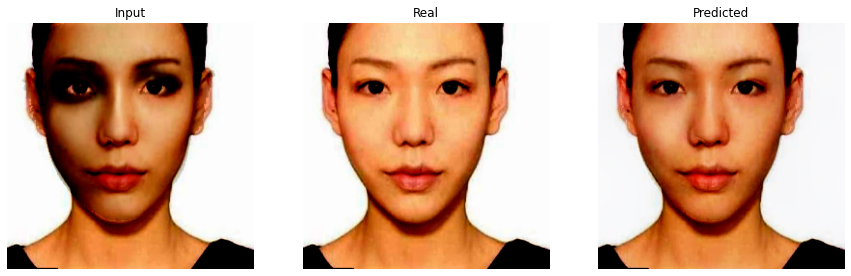

Save result successfully!
epoch: 142   loss: 232456.203125
-------- psnr:  29.899084    ----- epoch:  142   count:  100
epoch: 143   loss: 232106.609375
-------- psnr:  30.129261    ----- epoch:  143   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


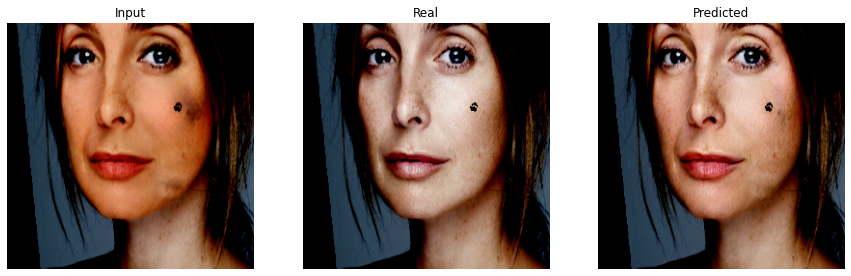

Save result successfully!
epoch: 144   loss: 229626.953125
-------- psnr:  30.035686    ----- epoch:  144   count:  100
epoch: 145   loss: 227445.09375
-------- psnr:  29.996878    ----- epoch:  145   count:  100
epoch: 146   loss: 226998.625
-------- psnr:  30.00103    ----- epoch:  146   count:  100
epoch: 147   loss: 228266.375
-------- psnr:  29.906757    ----- epoch:  147   count:  100
epoch: 148   loss: 225898.34375
-------- psnr:  30.029024    ----- epoch:  148   count:  100
epoch: 149   loss: 223553.296875
-------- psnr:  30.04043    ----- epoch:  149   count:  100
epoch: 150   loss: 220859.796875
-------- psnr:  30.083637    ----- epoch:  150   count:  100
epoch: 151   loss: 221425.265625
-------- psnr:  30.015892    ----- epoch:  151   count:  100
epoch: 152   loss: 222733.890625
-------- psnr:  30.085518    ----- epoch:  152   count:  100
epoch: 153   loss: 220576.0
-------- psnr:  30.070452    ----- epoch:  153   count:  100
epoch: 154   loss: 218098.34375
-------- psnr:  3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


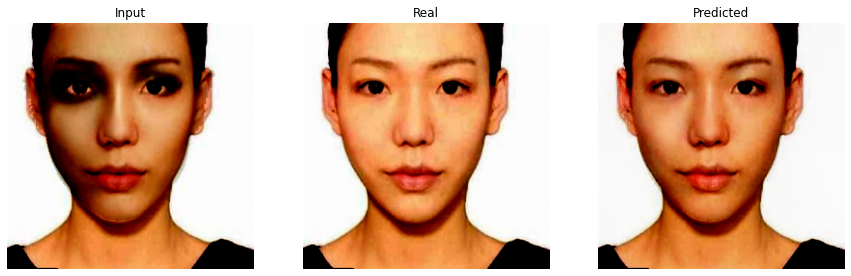

Save result successfully!
epoch: 191   loss: 181699.6875
-------- psnr:  29.900467    ----- epoch:  191   count:  100
epoch: 192   loss: 182927.9375
-------- psnr:  30.023748    ----- epoch:  192   count:  100
epoch: 193   loss: 182232.109375
-------- psnr:  30.077614    ----- epoch:  193   count:  100
epoch: 194   loss: 180712.234375
-------- psnr:  30.059422    ----- epoch:  194   count:  100
epoch: 195   loss: 180415.75
-------- psnr:  30.10942    ----- epoch:  195   count:  100
epoch: 196   loss: 179156.078125
-------- psnr:  30.062346    ----- epoch:  196   count:  100
epoch: 197   loss: 179699.65625
-------- psnr:  30.106377    ----- epoch:  197   count:  100
epoch: 198   loss: 179517.328125
-------- psnr:  30.05471    ----- epoch:  198   count:  100
epoch: 199   loss: 176050.046875
-------- psnr:  30.164862    ----- epoch:  199   count:  100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


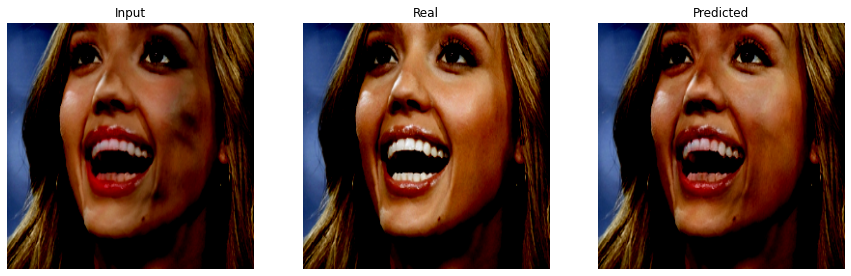

Save result successfully!


In [24]:
EPOCHS = 200
fit(train_dataset, EPOCHS, val_dataset)

### Save Results


In [25]:
res50Unet.save("./save_result/save_model/model-resnet-50-unet-final")

INFO:tensorflow:Assets written to: ./save_result/save_model/model-resnet-50-unet-final/assets


INFO:tensorflow:Assets written to: ./save_result/save_model/model-resnet-50-unet-final/assets


In [26]:
!zip -r save_result.zip save_result

/bin/bash: /home/notta/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  adding: save_result/ (stored 0%)
  adding: save_result/validation_results/ (stored 0%)
  adding: save_result/validation_results/epoch:105 pnsr:30.03537368774414.png (deflated 0%)
  adding: save_result/validation_results/epoch:68 pnsr:29.848234176635742.png (deflated 0%)
  adding: save_result/validation_results/epoch:129 pnsr:30.071399688720703.png (deflated 0%)
  adding: save_result/validation_results/epoch:53 pnsr:29.660730361938477.png (deflated 0%)
  adding: save_result/validation_results/epoch:7 pnsr:28.19361114501953.png (deflated 0%)
  adding: save_result/validation_results/epoch:15 pnsr:28.879751205444336.png (deflated 0%)
  adding: save_result/validation_results/epoch:44 pnsr:29.61927032470703.png (deflated 0%)
  adding: save_result/validation_results/epoch:46 pnsr:29.65711212158203.png (deflated 0%)
  adding: save_result/validation_results/epoch:71 pnsr:29.89

### Load model to use

In [27]:
# Load Model
from tensorflow import keras
res50Unet = keras.models.load_model('../input/model-unet-resnet50-l1/model-resnet-50-unet.h5')

OSError: No file or directory found at ../input/model-unet-resnet50-l1/model-resnet-50-unet.h5

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([256, 256,   3], dtype=int32)>

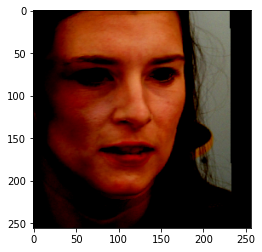

In [36]:
for inputs, targets in test_dataset.take(1):
    plt.imshow(inputs[0])

tf.shape(inputs[0])

## Evaluate Results

In [38]:
for _ in range(5):
    for inputs, targets in test_dataset.take(1):
        fake = res50Unet([inputs], training=True)
        print(inputs)
        plt.figure(figsize=(15,20))
        
        ########### YOUR CODE HERE (Optional) ################
        """ lấy ảnh đầu tiên của batch trong inputs, targets và fake
        sau đó scale về giá trị phù hợp để hiển thị theo matplotlib
        Note: matplotlib chỉ hiển thị được range [0,1] nếu dtype là float,
        và [0,255] nếu dtype là uint8
        Example: 
        --------
        display_list = [inputs[0], targets[0], fake[0]]

        """ 
        display_list = [inputs[0], targets[0], fake[0]]
        title = ['Input Left', 'Real Left', 'Predicted Left']    
        
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show() 

tf.Tensor(
[[[[ 0.26274514  0.254902    0.14509809]
   [ 0.34901965  0.37254906  0.24705887]
   [ 0.41960788  0.4431373   0.2941177 ]
   ...
   [ 0.20784318  0.1686275   0.0196079 ]
   [ 0.19215691  0.13725495  0.00392163]
   [ 0.18431377  0.12941182 -0.00392157]]

  [[ 0.27806377  0.26256132  0.16041672]
   [ 0.333701    0.35723042  0.23939955]
   [ 0.3889706   0.41250002  0.26348042]
   ...
   [ 0.22316182  0.18394613  0.03492641]
   [ 0.19981623  0.14491427  0.01158082]
   [ 0.16899514  0.11409318 -0.01158088]]

  [[ 0.28596818  0.25520837  0.13817406]
   [ 0.35594368  0.3794731   0.2467525 ]
   [ 0.41084564  0.44191182  0.27781868]
   ...
   [ 0.23106623  0.18431377  0.03529418]
   [ 0.18492651  0.13756132 -0.00330883]
   [ 0.1686275   0.11372554 -0.00422794]]

  ...

  [[-0.74056375 -0.6392157  -0.28596812]
   [-0.7091912  -0.638603   -0.2935049 ]
   [-0.7104167  -0.63982844 -0.33363968]
   ...
   [-0.72426474 -0.47450978  0.12971818]
   [-0.71703434 -0.46727943  0.13633573]
   [-

<Figure size 1080x1440 with 0 Axes>

<Figure size 1080x1440 with 0 Axes>

<Figure size 1080x1440 with 0 Axes>

<Figure size 1080x1440 with 0 Axes>

<Figure size 1080x1440 with 0 Axes>